In [3]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
from scipy.spatial.transform import Rotation as R

# import pmcpy as mcpy 
import numpy as np
import matplotlib.pyplot as plt
#from pmcpy import so3, Chain, RBP, Pivot, Crankshaft, Dumps, SingleTriad, ClusterTrans
import pmcpy.run.equilibrate as em # actually not equilibrate but energy minimization

# # # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# # import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Equilibrate

In [66]:
circular = True
control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*20
spline = mdna.SplineFrames(control_points)
dna = mdna.StructureGenerator(spline,circular=circular)
builder = mdna.Build(dna)
new_dna = builder.equilibrate(closed=circular)
traj = new_dna.get_traj()
print(new_dna.sequence)

ACTAAGTGCAGACCGGATAGTCGACGGTGGACCGCCCCGAAAATTGCGTCGATTAGGGGAATGATAGACGAGGTAACTGATCATCCATCGGTCGTGGGATCGCCGGTTCAGACATTATGTTAACCCAGGCAACTAGTCCGTCATCGAGGTGGACATATACCTTTTGACAAGGCAATT
cycle 0: 
46 moves initated
E = 769192.510410403 kT
E = 442555.053845572 kT
E = 325167.8822635221 kT
E = 204221.22674598574 kT
E = 100313.07551267819 kT
E = 34766.041262246385 kT
E = 6811.892368506978 kT
E = 1981.0047773214462 kT
E = 803.9518059677631 kT
E = 568.6929690755372 kT
E = 557.8037986291757 kT
E = 544.7274143948241 kT
E = 546.1251831176743 kT
46 moves initated
ACTAAGTGCAGACCGGATAGTCGACGGTGGACCGCCCCGAAAATTGCGTCGATTAGGGGAATGATAGACGAGGTAACTGATCATCCATCGGTCGTGGGATCGCCGGTTCAGACATTATGTTAACCCAGGCAACTAGTCCGTCATCGAGGTGGACATATACCTTTTGACAAGGCAATT


In [ ]:
view = nv.show_mdtraj(builder.get_MC_traj())
view

In [67]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

### Extend DNA

In [11]:
control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*1
spline = mdna.SplineFrames(control_points)
dna = mdna.StructureGenerator(spline)

ACGCCACGAG


In [39]:
builder = mdna.Build(dna, five_end='A')
builder.extend(nbp=5)
traj = builder.get_traj()
traj.save('test_extend.pdb')


view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('licorice')
view


cycle 0: 
2 moves initated
E = 81.25867472437581 kT
E = 25.149815399768922 kT
E = 23.55807239015204 kT
E = 23.27236185100824 kT
E = 23.718544366153743 kT
2 moves initated
CTCCTATGGGTTGCT


In [38]:
view = nv.show_mdtraj(builder.get_MC_traj())
view

NGLWidget(max_frame=75)

### Connect DNA's

In [80]:
control_points_A = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*1
control_points_B = control_points_A+5*2

spline_A = mdna.SplineFrames(control_points_A)
spline_B = mdna.SplineFrames(control_points_B)

dna_a = mdna.StructureGenerator(spline_A)
dna_b = mdna.StructureGenerator(spline_B)

builder = mdna.Build(dna_a, dna_b, five_end='A', three_end='B')
builder.connect()
traj = builder.get_traj()

TTAGCTTACG
TAGCCCTCGA
Optimal BP: 53, Twist Difference per BP: 0.323 degrees


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [9]:
view = nv.show_mdtraj(traj)
view.clear()
view.add_licorice(selection='all')
view

NGLWidget()

In [124]:
class Connect:

    def __init__(self, dna_a, dna_b, five_end='A', three_end='B',margin=1):
        self.dna_a = dna_a
        self.dna_b = dna_b
        self.frames_a = dna_a.spline.frames
        self.frames_b = dna_b.spline.frames

        self.five_end = five_end
        self.three_end = three_end
        self.margin = 1 # overlap between old and new sequence in direction of old sequence DNA
        self.bp_range = 100
        self.tolerance = np.abs((360 / 10.4) - (360 / 10.6))
        self.connect()

    def get_start_and_end(self):

        if self.five_end == 'A':
            self.start = self.frames_a[-1]
            self.end = self.frames_b[0]
        else:
            self.start = self.frames_b[-1]
            self.end = self.frames_a[0]

        
    def interplotate_points(self,start, end, n):
        return np.array([start + (end-start)*i/n for i in range(n+1)])
    
    def connect(self):

        # get the start and end of the connection
        self.get_start_and_end()

        # compute the rotation difference between the two frames (aka difference in twist per base pair)
        rotation_difference = self.get_twist_difference(self.start, self.end)

        # find optimal number of base pairs for the given range
        optimal_bps = self.find_optimal_bps(np.array([self.start[0], self.end[0]]), 
                                            bp_per_turn=10.5, 
                                            rise=0.34, 
                                            bp_range=self.bp_range, 
                                            rotation_difference=rotation_difference, 
                                            tolerance=self.tolerance, 
                                            plot=False
                                            )
        
        # get the optimal number of base pairs (smallest amount of base pairs that satisfies the tolerance)
        number_of_bp = optimal_bps[0]['optimal_bp']
        
        # interpolate control points for spline C
        control_points_C = self.interplotate_points(self.start[0], self.end[0], number_of_bp)
        distance = np.linalg.norm(self.start-self.end)
        spline_C = mdna.SplineFrames(control_points_C,frame_spacing=distance/len(control_points_C))
    
        # combine splines A B and C and remember the fixed nodes/frames of A and B
        # exclude first and last frame of A and B
        spline_C.frames = np.concatenate([self.frames_a[:-1],spline_C.frames,self.frames_b[1:]])

        # fix first and last 45 indices of total length of 257 frames
        fixed = list(range(self.frames_a.shape[0]-self.margin))+list(range(spline_C.frames.shape[0]-self.frames_b.shape[0]+self.margin,spline_C.frames.shape[0]))

        # make a random sequence for the new spline
        sequence = self.make_sequence(spline_C.frames.shape[0])

        # minimize the new spline with the fixed frames of A and B
        self.out = self.minimize_spline(spline_C, 
                                        sequence=sequence, 
                                        closed=False, 
                                        endpoints_fixed=False, 
                                        fixed=fixed, 
                                        exvol_rad=1
                                        )

        # create a trajectory from the new spline containing both the old and new parts
        dna_c = mdna.StructureGenerator(spline_C)

        # get the trajectory of the new spline
        self.traj = dna_c.get_traj()


    def get_MC_traj(self):
        """Get the MC sampling energy minimization trajectory of the new spline."""
        # get the xyz coordinates of the new spline
        xyz = np.array(self.out['confs'])
        # create a topology for the new spline
        topology = md.Topology()
        # add a chain to the topology
        chain = topology.add_chain()
        # add argon atoms to the topology
        for _ in range(xyz.shape[1]):
            residue = topology.add_residue(name='Ar', chain=chain)
            atom = topology.add_atom('Ar',element=md.element.argon, residue=residue)

        # add bonds to the topology
        bonds = np.array([[i,i+1] for i in range(xyz.shape[1]-1)])
        for bond in bonds:
            topology.add_bond(topology.atom(bond[0]),topology.atom(bond[1]))

        # create a trajectory from the xyz coordinates and the topology
        test = md.Trajectory(xyz,topology=topology)
        return test
    
    def get_traj(self):
        # get the trajectory of the new spline
        return self.traj
    
    def make_sequence(self,n_bp):
        # make a random sequence of n_bp base pairs
        return ''.join(['ATCG'[np.random.randint(4)] for i in range(n_bp)])

    def plot(self, pos, triads,ax=None):
        # plot the base pair frames
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        
        for position, frame in zip(pos,triads):
            right, up, forward = frame[:,0], frame[:,1], frame[:,2]
            ax.quiver(*position, *right, length=0.2, color='g')
            ax.quiver(*position, *up, length=0.2, color='b')
            ax.quiver(*position, *forward, length=0.2, color='r')

        ax.plot(*pos.T, color='black', label='Control Points',lw=1)
        ax.axis('equal')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()

    def plot_frames(self, spline,ax=None):
        # get the positions and triads of the base pair frames
        pos, triads = self.get_pos_and_triads(spline)
        # plot the base pair frames
        self.plot(pos, triads, ax=ax)

    def get_pos_and_triads(self, spline):
        # get origins of the base pair frames and the triads of the base pair frames (as column vectors for each frame)
        return spline.frames[:,0,:], spline.frames[:,1:,:].transpose((0, 2, 1))

    def update_spline(self, spline, out):
        # update the spline with new positions and triads
        spline.frames[:,0,:] = out['positions'] # set the origins of the frames
        spline.frames[:,1:,:] = out['triads'].transpose((0, 2, 1))# set the triads of the frames as row vectors
        
    def minimize_spline(self,spline, fixed=[], closed=False, sequence=None, endpoints_fixed=False, exvol_rad=0):
        # get the positions and triads of the base pair frames
        pos, triads = self.get_pos_and_triads(spline)

        # start with temperature annealing at 100000K
        out  = em.equilibrate(triads,pos,sequence=sequence,closed=closed,endpoints_fixed=endpoints_fixed,fixed=fixed,temp=100000,num_cycles=100,exvol_rad=exvol_rad)
        # then do a final equilibration at 300K
        out = em.equilibrate(out['triads'],out['positions'],sequence=sequence,closed=closed,endpoints_fixed=endpoints_fixed,fixed=fixed,temp=300,exvol_rad=exvol_rad)

        # update the spline with the new positions and triads
        self.update_spline(spline, out)

        return out

    def find_minima(self, lst):
        """Finds the indices of local minima in a list."""
        return [i for i in range(1, len(lst) - 1) if lst[i - 1] > lst[i] and lst[i + 1] > lst[i]]

    def compute_left_over(self, bp_range, min_bp, bp_per_turn, rotation_difference):
        """Computes the left-over rotational difference for a range of base pairs."""
        cumul_twist = np.arange(min_bp, min_bp + bp_range) * 360 / bp_per_turn
        return cumul_twist % 360 - rotation_difference

    def compute_twist_diff_per_bp(self, optimal_bp, left_over, min_bp):
        """Calculates the twist difference per base pair for an optimal base pair number."""
        total_twist_diff = left_over[optimal_bp - min_bp]
        return total_twist_diff / optimal_bp

    def check_within_tolerance(self, twist_diff_per_bp, tolerance):
        """Checks if the twist difference per base pair is within the specified tolerance."""
        return np.abs(twist_diff_per_bp) < tolerance

    def plot_leftover(self, min_bp,left_over):
        # Plotting the left-over rotational differences
        plt.plot(np.arange(min_bp, min_bp + len(left_over)), np.abs(left_over))
        plt.xlabel('Number of Base Pairs')
        plt.ylabel('Absolute Left Over')
        plt.show()

    def find_optimal_bps(self, positions, bp_per_turn, rise, bp_range, rotation_difference, tolerance, plot=False):
        """Finds optimal base pairs that satisfy the given tolerance.

        Args:
        positions: The positions of base pairs.
        bp_per_turn: Base pairs per turn.
        rise: Component of arc length.
        bp_range: Range of base pairs to consider.
        rotation_difference: The target rotation difference.
        tolerance: The tolerance for accepting an optimal base pair number.
        plot: If True, plots the left-over rotational differences.

        Returns:
        A list of dictionaries containing optimal base pair numbers and their twist differences per base pair.
        """
        min_arc = np.linalg.norm(positions[0] - positions[-1])
        min_bp = int(np.ceil(min_arc / rise))
        left_over = self.compute_left_over(bp_range, min_bp, bp_per_turn, rotation_difference)
        
        if plot:
            self.plot_leftover(min_bp,left_over)

        minima = self.find_minima(np.abs(left_over))
        results = []

        for min_val in minima:
            optimal_bp = min_bp + min_val
            twist_diff_per_bp = self.compute_twist_diff_per_bp(optimal_bp, left_over, min_bp)
            if self.check_within_tolerance(twist_diff_per_bp, tolerance):
                results.append({
                    'optimal_bp': optimal_bp ,
                    'twist_diff_per_bp': np.round(twist_diff_per_bp, 3)
                })
        if len(results) > 0:
            for result in results[:1]:
                print(f'Optimal BP: {result["optimal_bp"]}, Twist Difference per BP: {result["twist_diff_per_bp"]} degrees')
        else:
            print("No optimal number of base pairs found within the specified tolerance.")
        return results

    def compute_euler_angles(self, frame_A, frame_B):
        # Compute the rotation matrix R that transforms frame A to frame B
        rotation_matrix = np.dot(frame_B.T, frame_A)
        
        # Create a rotation object from the rotation matrix
        rotation = R.from_matrix(rotation_matrix)
        
        # Convert the rotation to Euler angles (ZYX convention)
        euler_angles = rotation.as_euler('zyx', degrees=True)
        
        # Return the Euler angles: yaw (Z), pitch (Y), and roll (X)
        return euler_angles

    def get_twist_difference(self, frame_a, frame_b):
        """Calculates the twist difference between two frames."""
        
        b1 = frame_a[1:]/np.linalg.norm(frame_a[1:])
        b2 = frame_b[1:]/np.linalg.norm(frame_b[1:])

        euler_angles = self.compute_euler_angles(b1, b2)
        return euler_angles[-1]

In [128]:
class Build:

    def __init__(self, dna_a, dna_b=None, five_end='A', three_end='B', margin=1):
        self.dna_a = dna_a
        self.dna_b = dna_b
        self.frames_a = dna_a.spline.frames if dna_a else None
        self.frames_b = dna_b.spline.frames if dna_b else None
        self.five_end = five_end 
        self.three_end = three_end
        self.margin = margin
        self.bp_range = 100 # should double check what this does again
        self.tolerance = np.abs((360 / 10.4) - (360 / 10.6))


    def connect(self):

        if not self.dna_b:
            raise ValueError("No second DNA sequence provided for connection.")
        
        # get the start and end of the connection
        self.get_start_and_end()

        # compute the rotation difference between the two frames (aka difference in twist per base pair)
        rotation_difference = self.get_twist_difference(self.start, self.end)

        # find optimal number of base pairs for the given range
        optimal_bps = self.find_optimal_bps(np.array([self.start[0], self.end[0]]), 
                                            bp_per_turn=10.5, 
                                            rise=0.34, 
                                            bp_range=self.bp_range, 
                                            rotation_difference=rotation_difference, 
                                            tolerance=self.tolerance, 
                                            plot=False
                                            )
        
        # get the optimal number of base pairs (smallest amount of base pairs that satisfies the tolerance)
        number_of_bp = optimal_bps[0]['optimal_bp']
        
        # interpolate control points for spline C
        control_points_C = self.interplotate_points(self.start[0], self.end[0], number_of_bp)
        distance = np.linalg.norm(self.start-self.end)
        spline_C = mdna.SplineFrames(control_points_C,frame_spacing=distance/len(control_points_C))
    
        # combine splines A B and C and remember the fixed nodes/frames of A and B
        # exclude first and last frame of A and B
        spline_C.frames = np.concatenate([self.frames_a[:-1],spline_C.frames,self.frames_b[1:]])

        # fix first and last 45 indices of total length of 257 frames
        fixed = list(range(self.frames_a.shape[0]-self.margin))+list(range(spline_C.frames.shape[0]-self.frames_b.shape[0]+self.margin,spline_C.frames.shape[0]))

        # make a random sequence for the new spline
        sequence = self.make_sequence(spline_C.frames.shape[0])

        # minimize the new spline with the fixed frames of A and B
        self.out = self.minimize_spline(spline_C, 
                                        sequence=sequence, 
                                        closed=False, 
                                        endpoints_fixed=False, 
                                        fixed=fixed, 
                                        exvol_rad=1
                                        )

        # create a trajectory from the new spline containing both the old and new parts
        dna_c = mdna.StructureGenerator(spline_C)

        # get the trajectory of the new spline
        self.traj = dna_c.get_traj()


    def extend(self, length=None, fixed_endpoint=None):
        # extend the DNA sequence in the specified direction using the five_end or three_end as reference

        # get the target frame for extension
        start = self.get_start()

        if length:
            pass

        # if fixed_endpoint:
        #     new_sequence = self.calculate_sequence_to_endpoint(target_frame, fixed_endpoint)
        # elif length:
        #     new_sequence = self.generate_sequence(target_frame, length)
        # else:
        #     raise ValueError("Either a fixed endpoint or a length must be specified for extension.")

        # self.apply_new_sequence(new_sequence, direction)

    def get_start(self):
        if self.five_end == 'A':
            return self.frames_a[-1]
        elif self.three_end == 'A':
            return self.frames_a[0]
        else:
            raise ValueError("No starting frame found for DNA sequence A.")

    def get_start_and_end(self):

        if self.five_end == 'A':
            self.start = self.frames_a[-1]
            self.end = self.frames_b[0]
        else:
            self.start = self.frames_b[-1]
            self.end = self.frames_a[0]

        
    def interplotate_points(self,start, end, n):
        return np.array([start + (end-start)*i/n for i in range(n+1)])
    
    def connect(self):

        # get the start and end of the connection
        self.get_start_and_end()

        # compute the rotation difference between the two frames (aka difference in twist per base pair)
        rotation_difference = self.get_twist_difference(self.start, self.end)

        # find optimal number of base pairs for the given range
        optimal_bps = self.find_optimal_bps(np.array([self.start[0], self.end[0]]), 
                                            bp_per_turn=10.5, 
                                            rise=0.34, 
                                            bp_range=self.bp_range, 
                                            rotation_difference=rotation_difference, 
                                            tolerance=self.tolerance, 
                                            plot=False
                                            )
        
        # get the optimal number of base pairs (smallest amount of base pairs that satisfies the tolerance)
        number_of_bp = optimal_bps[0]['optimal_bp']
        
        # interpolate control points for spline C
        control_points_C = self.interplotate_points(self.start[0], self.end[0], number_of_bp)
        distance = np.linalg.norm(self.start-self.end)
        spline_C = mdna.SplineFrames(control_points_C,frame_spacing=distance/len(control_points_C))
    
        # combine splines A B and C and remember the fixed nodes/frames of A and B
        # exclude first and last frame of A and B
        spline_C.frames = np.concatenate([self.frames_a[:-1],spline_C.frames,self.frames_b[1:]])

        # fix first and last 45 indices of total length of 257 frames
        fixed = list(range(self.frames_a.shape[0]-self.margin))+list(range(spline_C.frames.shape[0]-self.frames_b.shape[0]+self.margin,spline_C.frames.shape[0]))

        # make a random sequence for the new spline
        sequence = self.make_sequence(spline_C.frames.shape[0])

        # minimize the new spline with the fixed frames of A and B
        self.out = self.minimize_spline(spline_C, 
                                        sequence=sequence, 
                                        closed=False, 
                                        endpoints_fixed=False, 
                                        fixed=fixed, 
                                        exvol_rad=1
                                        )

        # create a trajectory from the new spline containing both the old and new parts
        dna_c = mdna.StructureGenerator(spline_C)

        # get the trajectory of the new spline
        self.traj = dna_c.get_traj()


    def get_MC_traj(self):
        """Get the MC sampling energy minimization trajectory of the new spline."""
        # get the xyz coordinates of the new spline
        xyz = np.array(self.out['confs'])
        # create a topology for the new spline
        topology = md.Topology()
        # add a chain to the topology
        chain = topology.add_chain()
        # add argon atoms to the topology
        for _ in range(xyz.shape[1]):
            residue = topology.add_residue(name='Ar', chain=chain)
            atom = topology.add_atom('Ar',element=md.element.argon, residue=residue)

        # add bonds to the topology
        bonds = np.array([[i,i+1] for i in range(xyz.shape[1]-1)])
        for bond in bonds:
            topology.add_bond(topology.atom(bond[0]),topology.atom(bond[1]))

        # create a trajectory from the xyz coordinates and the topology
        test = md.Trajectory(xyz,topology=topology)
        return test
    
    def get_traj(self):
        # get the trajectory of the new spline
        return self.traj
    
    def make_sequence(self,n_bp):
        # make a random sequence of n_bp base pairs
        return ''.join(['ATCG'[np.random.randint(4)] for i in range(n_bp)])

    def plot(self, pos, triads,ax=None):
        # plot the base pair frames
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
        
        for position, frame in zip(pos,triads):
            right, up, forward = frame[:,0], frame[:,1], frame[:,2]
            ax.quiver(*position, *right, length=0.2, color='g')
            ax.quiver(*position, *up, length=0.2, color='b')
            ax.quiver(*position, *forward, length=0.2, color='r')

        ax.plot(*pos.T, color='black', label='Control Points',lw=1)
        ax.axis('equal')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()

    def plot_frames(self, spline,ax=None):
        # get the positions and triads of the base pair frames
        pos, triads = self.get_pos_and_triads(spline)
        # plot the base pair frames
        self.plot(pos, triads, ax=ax)

    def get_pos_and_triads(self, spline):
        # get origins of the base pair frames and the triads of the base pair frames (as column vectors for each frame)
        return spline.frames[:,0,:], spline.frames[:,1:,:].transpose((0, 2, 1))

    def update_spline(self, spline, out):
        # update the spline with new positions and triads
        spline.frames[:,0,:] = out['positions'] # set the origins of the frames
        spline.frames[:,1:,:] = out['triads'].transpose((0, 2, 1))# set the triads of the frames as row vectors
        
    def minimize_spline(self,spline, fixed=[], closed=False, sequence=None, endpoints_fixed=False, exvol_rad=0):
        # get the positions and triads of the base pair frames
        pos, triads = self.get_pos_and_triads(spline)

        # start with temperature annealing at 100000K
        out  = em.equilibrate(triads,pos,sequence=sequence,closed=closed,endpoints_fixed=endpoints_fixed,fixed=fixed,temp=100000,num_cycles=100,exvol_rad=exvol_rad)
        # then do a final equilibration at 300K
        out = em.equilibrate(out['triads'],out['positions'],sequence=sequence,closed=closed,endpoints_fixed=endpoints_fixed,fixed=fixed,temp=300,exvol_rad=exvol_rad)

        # update the spline with the new positions and triads
        self.update_spline(spline, out)

        return out

    def find_minima(self, lst):
        """Finds the indices of local minima in a list."""
        return [i for i in range(1, len(lst) - 1) if lst[i - 1] > lst[i] and lst[i + 1] > lst[i]]

    def compute_left_over(self, bp_range, min_bp, bp_per_turn, rotation_difference):
        """Computes the left-over rotational difference for a range of base pairs."""
        cumul_twist = np.arange(min_bp, min_bp + bp_range) * 360 / bp_per_turn
        return cumul_twist % 360 - rotation_difference

    def compute_twist_diff_per_bp(self, optimal_bp, left_over, min_bp):
        """Calculates the twist difference per base pair for an optimal base pair number."""
        total_twist_diff = left_over[optimal_bp - min_bp]
        return total_twist_diff / optimal_bp

    def check_within_tolerance(self, twist_diff_per_bp, tolerance):
        """Checks if the twist difference per base pair is within the specified tolerance."""
        return np.abs(twist_diff_per_bp) < tolerance

    def plot_leftover(self, min_bp,left_over):
        # Plotting the left-over rotational differences
        plt.plot(np.arange(min_bp, min_bp + len(left_over)), np.abs(left_over))
        plt.xlabel('Number of Base Pairs')
        plt.ylabel('Absolute Left Over')
        plt.show()

    def find_optimal_bps(self, positions, bp_per_turn, rise, bp_range, rotation_difference, tolerance, plot=False):
        """Finds optimal base pairs that satisfy the given tolerance.

        Args:
        positions: The positions of base pairs.
        bp_per_turn: Base pairs per turn.
        rise: Component of arc length.
        bp_range: Range of base pairs to consider.
        rotation_difference: The target rotation difference.
        tolerance: The tolerance for accepting an optimal base pair number.
        plot: If True, plots the left-over rotational differences.

        Returns:
        A list of dictionaries containing optimal base pair numbers and their twist differences per base pair.
        """
        min_arc = np.linalg.norm(positions[0] - positions[-1])
        min_bp = int(np.ceil(min_arc / rise))
        left_over = self.compute_left_over(bp_range, min_bp, bp_per_turn, rotation_difference)
        
        if plot:
            self.plot_leftover(min_bp,left_over)

        minima = self.find_minima(np.abs(left_over))
        results = []

        for min_val in minima:
            optimal_bp = min_bp + min_val
            twist_diff_per_bp = self.compute_twist_diff_per_bp(optimal_bp, left_over, min_bp)
            if self.check_within_tolerance(twist_diff_per_bp, tolerance):
                results.append({
                    'optimal_bp': optimal_bp ,
                    'twist_diff_per_bp': np.round(twist_diff_per_bp, 3)
                })
        if len(results) > 0:
            for result in results[:1]:
                print(f'Optimal BP: {result["optimal_bp"]}, Twist Difference per BP: {result["twist_diff_per_bp"]} degrees')
        else:
            print("No optimal number of base pairs found within the specified tolerance.")
        return results

    def compute_euler_angles(self, frame_A, frame_B):
        # Compute the rotation matrix R that transforms frame A to frame B
        rotation_matrix = np.dot(frame_B.T, frame_A)
        
        # Create a rotation object from the rotation matrix
        rotation = R.from_matrix(rotation_matrix)
        
        # Convert the rotation to Euler angles (ZYX convention)
        euler_angles = rotation.as_euler('zyx', degrees=True)
        
        # Return the Euler angles: yaw (Z), pitch (Y), and roll (X)
        return euler_angles

    def get_twist_difference(self, frame_a, frame_b):
        """Calculates the twist difference between two frames."""
        
        b1 = frame_a[1:]/np.linalg.norm(frame_a[1:])
        b2 = frame_b[1:]/np.linalg.norm(frame_b[1:])

        euler_angles = self.compute_euler_angles(b1, b2)
        return euler_angles[-1]

In [125]:
control_points_A = np.array([[0,0,-1],[0,1,0],[0,2,0],[0,3,0]])*5
control_points_B = np.array([[5,3,5],[5,3,6],[5,3,7],[5,4,8]])*5

control_points_A = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])*1
control_points_B = control_points_A+5*2

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(*control_points_A.T,'-o', color='black', label='Control Points A',lw=1)
# ax.plot(*control_points_B.T,'-o', color='red', label='Control Points B',lw=1)
# ax.axis('equal')


spline_A = mdna.SplineFrames(control_points_A)
spline_B = mdna.SplineFrames(control_points_B)

dna_a = mdna.StructureGenerator(spline_A)
dna_b = mdna.StructureGenerator(spline_B)

connection = Connect(dna_a, dna_b, five_end='A', three_end='B')


GGAAGACTTC
CGACACGGTT
Optimal BP: 53, Twist Difference per BP: 0.323 degrees
cycle 0: 
13 moves initated
E = 696.2865492508504 kT
E = 279.1494766655762 kT
E = 246.75528052476363 kT
E = 229.46291346326126 kT
E = 217.62259373224506 kT
E = 217.60120121310982 kT
E = 214.62073250843153 kT
E = 214.35770203275962 kT
E = 215.06100857471313 kT
13 moves initated
CCTTTTAAGGTCTGTCGAGTGCGTCAGCCGGAACAGCTTCTCCATGGCCAAAGTCTGGTAGATTCAAACTGCG


In [126]:
traj = connection.get_traj()
mc_traj = connection.get_MC_traj()
view = nv.show_mdtraj(mc_traj[::5])
view

NGLWidget(max_frame=175)

In [127]:
view = nv.show_mdtraj(traj)
view

NGLWidget()

In [96]:
start = spline_A.frames[-1]
end = spline_B.frames[0]

rotation_difference = get_twist_difference(start, end)

bp_per_turn = 10.5
rise = 0.34
bp_range = 100
tolerance = np.abs((360 / 10.4) - (360 / 10.6))

optimal_bps = find_optimal_bps(np.array([start[0], end[0]]), bp_per_turn, rise, bp_range, rotation_difference, tolerance, plot=False)
print(optimal_bps[:5])

Optimal BP: 53, Twist Difference per BP: 0.323 degrees
[{'optimal_bp': 53, 'twist_diff_per_bp': 0.323}, {'optimal_bp': 63, 'twist_diff_per_bp': 0.0}, {'optimal_bp': 74, 'twist_diff_per_bp': 0.232}, {'optimal_bp': 84, 'twist_diff_per_bp': 0.0}, {'optimal_bp': 95, 'twist_diff_per_bp': 0.18}]


53


(-2.1500000000000004,
 12.15,
 -0.6500000000000004,
 13.65,
 -0.3625000000000007,
 10.3625)

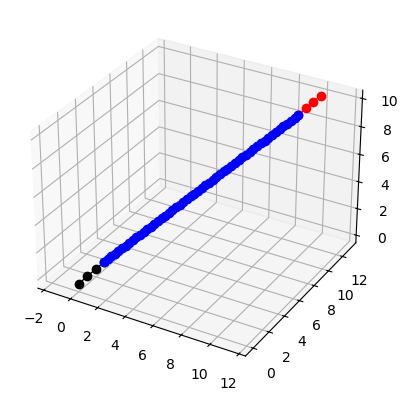

In [82]:
def interplotate_points(start, end, n):
    return np.array([start + (end-start)*i/n for i in range(n+1)])

number_of_bp = optimal_bps[0]['optimal_bp']
print(number_of_bp)
control_points_C = interplotate_points(start[0], end[0], number_of_bp)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points_A.T,'-o', color='black', label='Control Points A',lw=1)
ax.plot(*control_points_B.T,'-o', color='red', label='Control Points B',lw=1)
ax.plot(*control_points_C.T,'-o', color='blue', label='Control Points C',lw=1)
ax.axis('equal')

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

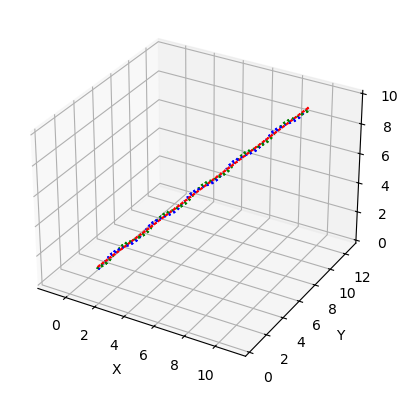

In [83]:

distance = np.linalg.norm(start-end)
spline_C = mdna.SplineFrames(control_points_C,frame_spacing=distance/len(control_points_C))
spline_C.plot_frames(equal=True)

In [84]:
# combine splines A B and C and remember the fixed nodes/frames of A and B
# exclude first and last frame of A and B
spline_C.frames = np.concatenate([spline_A.frames[:-1],spline_C.frames,spline_B.frames[1:]])

In [85]:
spline_C.frames.shape,spline_A.frames.shape, spline_B.frames.shape
# fix first and last 45 indices of total length of 257 frames
margin = 1
fixed = list(range(spline_A.frames.shape[0]-margin))+list(range(spline_C.frames.shape[0]-spline_B.frames.shape[0]+margin,spline_C.frames.shape[0]))

In [86]:
sequence = make_sequence(spline_C.frames.shape[0])
sequence

'GGGTTTGTTGGTTCCTAGAGTTGTACTCATCAGGCCACGCACTCTTGCTAAATCCAACACGAGCCGGCGTATA'

In [87]:
out = minimize_spline(spline_C, sequence=sequence, closed=False, endpoints_fixed=False, fixed=fixed, exvol_rad=1)

cycle 0: 
13 moves initated
E = 760.0579583031094 kT
E = 280.60424419226496 kT
E = 254.71794673889687 kT
E = 242.07968711231464 kT
E = 230.33171225538055 kT
E = 217.66128407095886 kT
E = 214.90732822069677 kT
E = 214.95016567593245 kT
13 moves initated


In [95]:
import mdtraj as md
import nglview as nv

xyz = np.array(out['confs'])
print(xyz.shape)

topology = md.Topology()
chain = topology.add_chain()
for i in range(xyz.shape[1]):
    residue = topology.add_residue(name='Ar', chain=chain)
    atom = topology.add_atom('Ar',element=md.element.argon, residue=residue)

bonds = np.array([[i,i+1] for i in range(xyz.shape[1]-1)])
for bond in bonds:
    topology.add_bond(topology.atom(bond[0]),topology.atom(bond[1]))

test = md.Trajectory(xyz,topology=topology)
view = nv.show_mdtraj(test[::1])
view.clear()
view.add_representation('ball+stick',radius=0.5,color='black')
view

(151, 73, 3)


NGLWidget(max_frame=150)

In [89]:

dna_c = mdna.StructureGenerator(spline_C)
traj = dna_c.get_traj()
view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('licorice', selection='all')
view

CGGGGCGAATGAATCGGTCATACCTAAGAATGCTCAACAGACGACACCTCATGGATGTTGGCTGCCCCATCTG


NGLWidget()

In [90]:
traj.save('final.pdb')